# Evaluating a Function that Extracts Project Names from Customer Emails

Evaluating a function that extracts project names from customer emails requires both **quantitative metrics** and a **systematic approach** to assess its accuracy and performance. Since there is a **ground truth CSV file** containing both the expected project names and the customer email content, we can measure how well the function performs by comparing its outputs with the expected results.

### The Evaluation Metrics
The most appropriate metrics for this task are:

- **Accuracy**: Measures how often the function correctly extracts the project name. It's the ratio of correctly identified project names to the total number of cases.
- **Precision**: Measures the percentage of correctly extracted project names among all names extracted by the function.
- **Recall**: Measures how many of the actual project names were correctly extracted by the function.
- **F1 Score**: A harmonic mean of precision and recall, useful when you want a balance between precision and recall.


In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from services.content.project_identifier_service import ProjectIdentifierService
from agents.projects_agent import ProjectsAgent
from dtos.project import Project

from importlib import reload
from dtos.identified_project import IdentifiedProject

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ground_truth_csv_path = "/home/jovyan/work/notebook/project_name_extractor_evaluation/ground_truth.csv"

In [3]:
# Read Ground Truth CSV Data
data = pd.read_csv(ground_truth_csv_path, delimiter=";")

# Load the data into a DataFrame
df = pd.DataFrame(data)

Replace "NaN" with an empty string in the expected project names to avoid issues with comparison.

In [4]:
df = df.fillna("")

In [5]:
df

,source_system,project_id,project_name,subject,body
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh..."
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E..."
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ..."
...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...


In [6]:
projects = ProjectsAgent.get_projects()
filtered_project_names = [project.name for project in projects if 'Spendenprojekt - Green Forest Fund' not in project.name]
project_identifier_service = ProjectIdentifierService(filtered_project_names)

In [12]:
filtered_project_names

['DFI Zukunftspark Oberfranken VI',
 'Berliner Flair in Friedrichshain II',
 'DFI Zukunftspark Nordbayern IV',
 'DFI Zukunftspark Oberfranken V',
 'Am Akkonplatz',
 'Berliner Flair in Friedrichshain',
 'DFI Zukunftspark Oberfranken IV',
 'Tonhallen-Passage II',
 'DFI Zukunftspark Nordbayern III',
 'DFI Zukunftspark Oberfranken III',
 'DFI Zukunftspark Dreiländereck II',
 'Friedrichstraße 191 III',
 'Office am Europaring IV',
 'DFI Zukunftspark Mittelfranken',
 'Wohnquartier Pasing II',
 'DFI Zukunftspark Dreiländereck',
 'smart-UP Self-Storage-Park III',
 'Stadthaus Mozart IV',
 'Stadthaus Mozart III',
 'Büro-Hochhaus am Scheidemannplatz II',
 'smartUP Self-Storage-Park II',
 'Jugendstil-Altbau am Rothenbaum II',
 'Stadtleben Altlindenau',
 'An der Kleinen Weser',
 'Modernes Wohnen am Nymphenburger Kanal II',
 'Atelier-Wohnungen an der Burg II',
 'Eco Living Lichtenrade',
 'The Five',
 'Elegantes Wohnen nahe der Isar',
 'Solarpark Eyendorf',
 'DFI Zukunftspark Oberrhein II',
 'DFI Zuku

In [7]:

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_as_dict = row.to_dict()
    input_text = (row_as_dict["subject"] + " " + row_as_dict["body"]).strip()
    extracted_project: IdentifiedProject = project_identifier_service.extract_project(input_text)
    if extracted_project == None:
        df.at[idx, "extracted_project_name"] = ""
        continue

    df.at[idx, "extracted_project_name"] = extracted_project.name
    df.at[idx, "extracted_project_similarity"] = extracted_project.similarity

  0%|          | 0/212 [00:00<?, ?it/s]

100%|██████████| 212/212 [07:14<00:00,  2.05s/it]


In [8]:
df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",DFI Zukunftspark Oberfranken VI,0.471477
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,DFI Zukunftspark Oberfranken VI,0.467851
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",DFI Zukunftspark Oberfranken VI,0.529378
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,DFI Zukunftspark Oberfranken VI,0.471626
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",DFI Zukunftspark Oberfranken VI,0.527324
...,...,...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,NaN
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...,,NaN
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...,,NaN
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...,,NaN


In [9]:
# Ground truth and predictions
y_true = df['project_name']
y_pred = df['extracted_project_name']

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9528301886792453
Precision: 0.9595238095238094
Recall: 0.944047619047619
F1 Score: 0.9466433037861609


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Analyze the results

Find rows where the values are not the same

In [10]:
mask = df["project_name"] != df["extracted_project_name"]
different_values_df = df[mask]

different_values_df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
43,evdi,4973E74A-E88E-4E1B-B534-36615368D4A6,Tonhallen-Passage II,Sicherheitsaspekte und Risikoabsicherung des P...,"Guten Tag, als potenzieller Investor möchte ic...",,NaN
44,evdi,4973E74A-E88E-4E1B-B534-36615368D4A6,Tonhallen-Passage II,Fragen zur Projektdauer und Auszahlungsmodalit...,"Sehr geehrtes Projektteam, ich habe einige Fra...",,NaN
45,evdi,4973E74A-E88E-4E1B-B534-36615368D4A6,Tonhallen-Passage II,Nachhaltigkeitskonzept und energetische Sanierung,"Liebe Projektverantwortliche, als umweltbewuss...",,NaN
48,evdi,35F259F1-4160-4768-9C7A-9ECBDA485BA0,DFI Zukunftspark Nordbayern III,Laufzeit und Auszahlungsmodalitäten des DFI Zu...,"Guten Tag, ich habe großes Interesse an einer ...",DFI Zukunftspark Nordbayern,0.328448
68,evdi,A0D1803B-9018-4774-82A4-AAB4668E19C6,Friedrichstraße 191 III,Welche Rückzahlungsmodalitäten gibt es?,Welche Rückzahlungsmodalitäten sind für mein I...,,NaN
81,evdi,9C0D39D1-E98B-4C90-BE38-A3C6CC02E79A,Wohnquartier Pasing II,Fragen zur Projektlaufzeit und Auszahlungsmoda...,"Sehr geehrtes Projektteam, ich habe einige Fra...",,NaN
114,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Sicherheiten und Risikoabsicherung beim Immobi...,"Sehr geehrte Damen und Herren, als potenzielle...",Atelier-Wohnungen an der Burg II,0.230603
158,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Wie wird die Rendite beim Spendenprojekt - Gre...,Wie wird die Rendite in diesem Projekt berechn...,,NaN
159,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Wie hoch ist das Risiko für das Spendenprojekt...,Wie wird das Risiko dieses Projekts bewertet u...,,NaN
160,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Sicherheit und Renditepotenzial?,Welche Sicherheitsmaßnahmen gibt es beim Green...,,NaN


Let's investigate some of them:

In [16]:
expected_project_name = "Am Akkonplatz"
input_text = "Wie ist das Risiko beim Projekt Am Akkonplatz eingeschätzt? Wie wird das Risiko bei diesem Investment eingeschätzt? Gibt es Schutzmechanismen, um mein Kapital zu sichern, falls das Projekt nicht erfolgreich ist?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

IdentifiedProject(name='Am Akkonplatz', similarity=0.2073156237602234)

In [17]:
expected_project_name = "Wohnquartier Pasing II"
input_text = "Fragen zur Projektlaufzeit und Auszahlungsmodalitäten Sehr geehrtes Projektteam, ich habe einige Fragen bezüglich der zeitlichen Aspekte und Auszahlungsmodalitäten des Investments. Wie lange ist die geplante Laufzeit des Wohnprojekts in Pasing? Ab wann können Investoren mit den ersten Ausschüttungen rechnen? Gibt es einen festen Auszahlungsplan oder sind die Zahlungen an bestimmte Meilensteine im Bauprozess geknüpft? Besteht die Möglichkeit einer vorzeitigen Kündigung oder eines Verkaufs der Anteile? Ich würde mich über detaillierte Informationen zu diesen Punkten sehr freuen, da sie für meine Investitionsplanung von großer Bedeutung sind. Das Projekt ist Wohnquartier Pasing II"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

In [19]:
expected_project_name = "Büro-Hochhaus am Scheidemannplatz II"
input_text = "Sicherheiten und Risikoabsicherung beim Immobilieninvestment Sehr geehrte Damen und Herren, als potenzieller Investor möchte ich mich nach den Sicherheiten erkundigen, die Sie für Investments in Ihr Projekt bieten. Welche konkreten Maßnahmen haben Sie ergriffen, um das Risiko für Investoren zu minimieren? Gibt es eine Absicherung durch Grundbucheinträge oder andere rechtliche Konstrukte? Mich würde auch interessieren, wie Sie mit möglichen Verzögerungen im Bauprozess oder unerwarteten Kostensteigerungen umgehen. Beim Projekt Büro-Hochhaus am Scheidemannplatz II, wie stellen Sie sicher, dass die Interessen der Investoren gewahrt bleiben?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

IdentifiedProject(name='Atelier-Wohnungen an der Burg II', similarity=0.23060311377048492)

Check how many unique project names are in the dataset and how often they appear:

In [20]:
print(df['project_name'].value_counts())

project_name
                                             24
DFI Zukunftspark Dreiländereck                8
DFI Zukunftspark Nordbayern IV                6
DFI Zukunftspark Oberfranken V                6
Am Akkonplatz                                 6
Berliner Flair in Friedrichshain              6
DFI Zukunftspark Oberfranken IV               6
DFI Zukunftspark Nordbayern III               6
DFI Zukunftspark Oberfranken VI               6
Berliner Flair in Friedrichshain II           6
smartUP Self-Storage-Park II                  6
DFI Zukunftspark Oberfranken III              6
Wohnquartier Pasing II                        6
DFI Zukunftspark Dreiländereck II             6
smart-UP Self-Storage-Park III                6
Stadthaus Mozart IV                           6
Büro-Hochhaus am Scheidemannplatz II          6
DFI Zukunftspark Mittelfranken                6
Stadthaus Mozart III                          6
Tonhallen-Passage II                          5
Stadthaus 'Mozart'         

Compare Predictions and Ground Truth:

In [21]:
mismatches = df[df['project_name'] != df['extracted_project_name']]
print(mismatches[['project_name', 'extracted_project_name']])

                             project_name            extracted_project_name
43                   Tonhallen-Passage II                                  
44                   Tonhallen-Passage II                                  
45                   Tonhallen-Passage II                                  
48        DFI Zukunftspark Nordbayern III       DFI Zukunftspark Nordbayern
68                Friedrichstraße 191 III                                  
81                 Wohnquartier Pasing II                                  
114  Büro-Hochhaus am Scheidemannplatz II  Atelier-Wohnungen an der Burg II
158    Spendenprojekt - Green Forest Fund                                  
159    Spendenprojekt - Green Forest Fund                                  
160    Spendenprojekt - Green Forest Fund                                  


## Examine Confusion Matrix
The **confusion matrix** is an important tool to evaluate the performance of a classification model. It provides a detailed breakdown of how the model's predictions compare to the actual results, allowing you to pinpoint where your model performs well and where it makes mistakes.

#### **What is a Confusion Matrix?**
A **confusion matrix** is a table that shows the actual versus predicted classifications. It helps you see how many times the model correctly predicted each class and where it made errors. For each class (in your case, a project name), the matrix tracks four important types of predictions:
1. **True Positives (TP)**: Correct predictions where the model predicted a class and it was actually that class.
2. **False Positives (FP)**: Incorrect predictions where the model predicted a class, but it should have predicted a different class.
3. **False Negatives (FN)**: Missed predictions where the model failed to predict a class that was the actual class.
4. **True Negatives (TN)**: Correct rejections where the model correctly predicted a different class.

For **multiclass classification**, the confusion matrix will be larger, showing a grid where the rows represent the **actual labels** and the columns represent the **predicted labels**.

#### **Structure of a Confusion Matrix**
For your use case, where you're classifying project names, the confusion matrix will look something like this:

|                | Predicted: Project A | Predicted: Project B | Predicted: Project C |
|----------------|----------------------|----------------------|----------------------|
| Actual: Project A | TP (Correct)         | FP (Incorrect)        | FP (Incorrect)        |
| Actual: Project B | FN (Miss)            | TP (Correct)         | FP (Incorrect)        |
| Actual: Project C | FN (Miss)            | FN (Miss)            | TP (Correct)          |

- **Diagonal elements** (from top-left to bottom-right) represent **True Positives (TP)**—correct predictions.
- **Off-diagonal elements** (the other cells) represent errors, either **False Positives (FP)** or **False Negatives (FN)**.


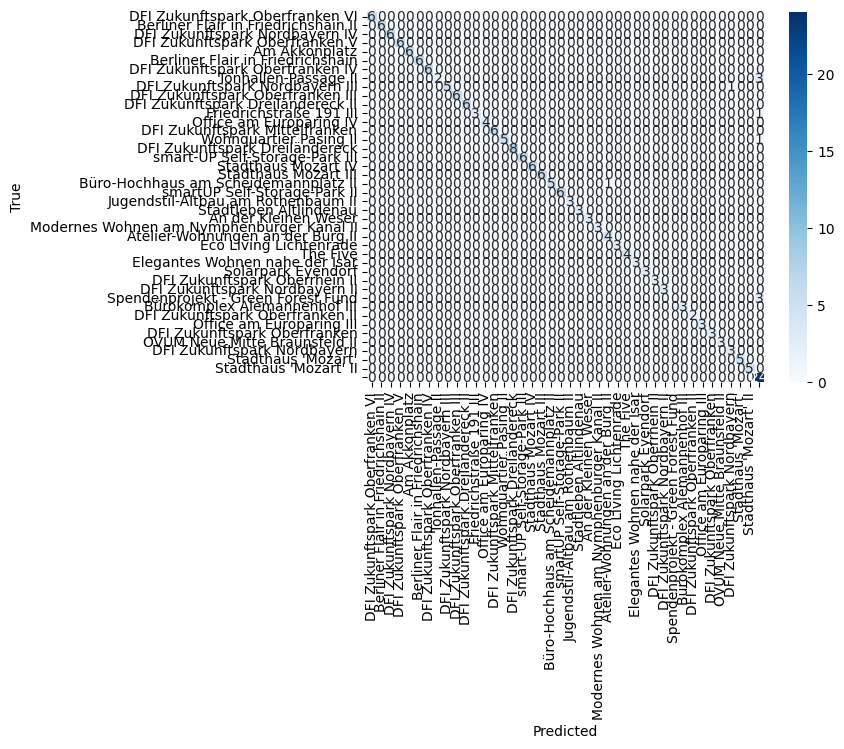

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=df['project_name'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['project_name'].unique(), yticklabels=df['project_name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **How to Use the Confusion Matrix to Improve Results**
1. **Identify Specific Errors**: 
   - The confusion matrix tells you which project names the model confuses with each other. For example, if `Project A` is frequently misclassified as `Project B`, you can investigate why this happens. Is there a pattern in the data that leads to these confusions? Do `Project A` and `Project B` have similar names, or do the email bodies have similar content?

2. **Class Imbalance**:
   - If you see that some projects are misclassified more often than others, it might indicate a **class imbalance**. In this case, you can consider techniques like **oversampling** the minority class (rare projects) or **undersampling** the majority class (frequent projects).

3. **Model Tuning**:
   - The confusion matrix helps you focus on **precision and recall** for individual classes. If a particular class (project) has a low recall (many false negatives), you can adjust the threshold for classification to be more sensitive to that class. Similarly, if precision is low, you might want to make the model more conservative about predicting that class.

4. **Feature Engineering**:
   - If specific classes are frequently misclassified, you might need to refine your **text extraction function** to better distinguish between them. For instance, you can extract additional features from the email content (like keywords, entities, or semantic context) to improve the classifier’s accuracy.

## The similarity of the project names

In [23]:
mask = df["project_name"] == df["extracted_project_name"]
correct_predicted_values = df[mask]

correct_predicted_values

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",DFI Zukunftspark Oberfranken VI,0.471477
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,DFI Zukunftspark Oberfranken VI,0.467851
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",DFI Zukunftspark Oberfranken VI,0.529378
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,DFI Zukunftspark Oberfranken VI,0.471626
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",DFI Zukunftspark Oberfranken VI,0.527324
...,...,...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,NaN
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...,,NaN
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...,,NaN
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...,,NaN


In [24]:
similarity_min = df["extracted_project_similarity"].min()
similarity_min

np.float64(0.20237024128437042)

In [25]:
df["extracted_project_similarity"].describe()

count    180.000000
mean       0.392037
std        0.095475
min        0.202370
25%        0.318772
50%        0.395703
75%        0.463763
max        0.635813
Name: extracted_project_similarity, dtype: float64

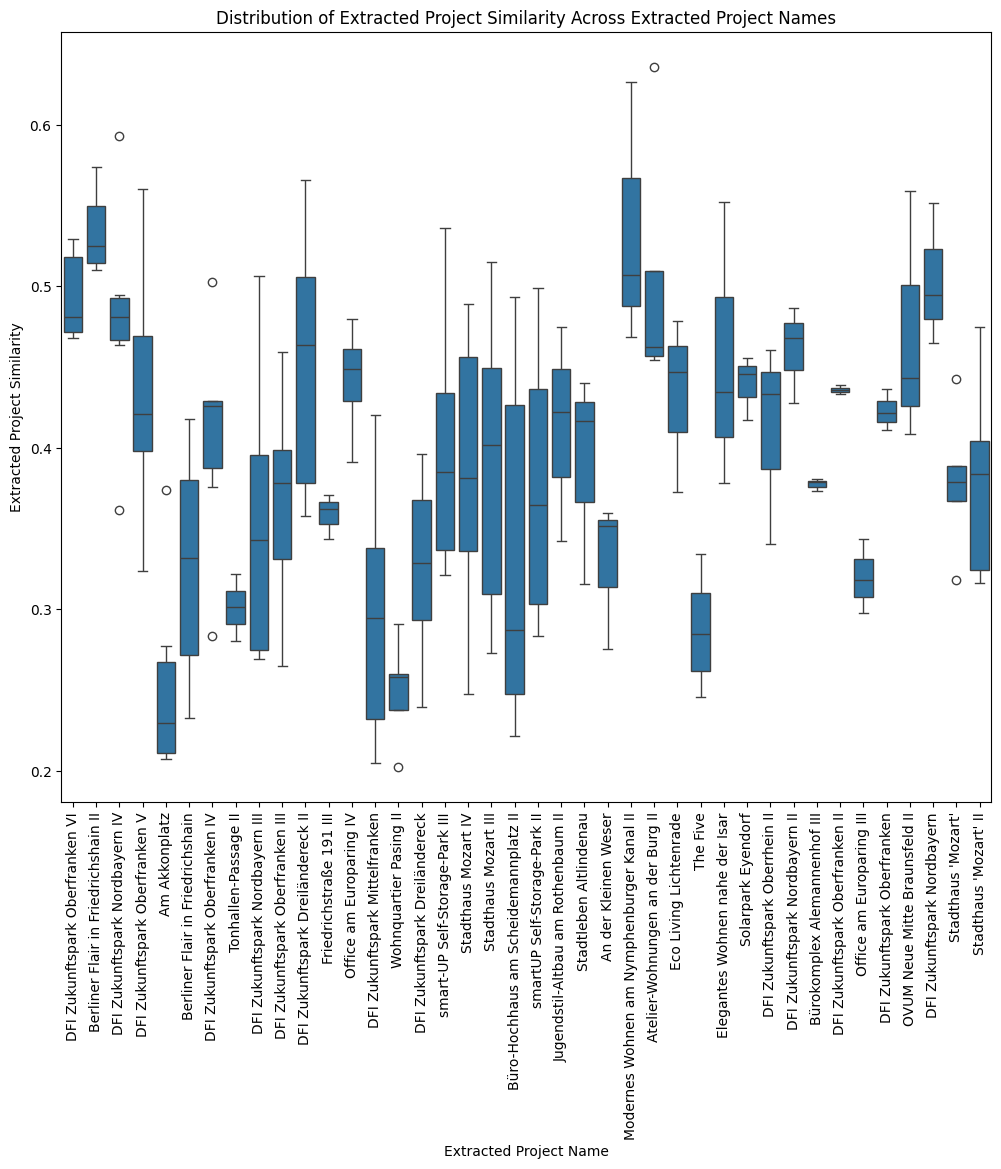

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows where 'extracted_project_similarity' is NaN
df_filtered = correct_predicted_values[correct_predicted_values["extracted_project_similarity"].notna()]

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a box plot
sns.boxplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Optionally, create a violin plot instead of a box plot
# sns.violinplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title("Distribution of Extracted Project Similarity Across Extracted Project Names")
plt.xlabel("Extracted Project Name")
plt.ylabel("Extracted Project Similarity")

# Show the plot
plt.show()